## Visualizing 2P responses to stimulus

Some of this content is adapted from the [Allen SDK Documentation](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_session.html).

After processing Neuropixel ecephys data with [Kilosort](https://github.com/MouseLand/Kilosort), individual neuronal units have been identified and are stored in the Units table, in the `Units` section of the NWB file. The Units table contains information about hypothetical neurons determined by Kilosort. With this information, and the stimulus information found in the stimulus tables of the `Intervals` section, this notebook helps examine the spiking behavior of these units in response to stimulus and their associated waveforms

### Environment Setup

In [4]:
import os

import fsspec
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from dandi import dandiapi
from fsspec.implementations.cached import CachingFileSystem
from pynwb import NWBHDF5IO

%matplotlib inline

### Downloading 2P File

In [69]:
dandiset_id = "000021"
dandi_filepath = "sub_1170622509+sess_1194683535+exp_1194752574_ophys.nwb"
authenticate = False
# dandi_api_key = os.environ['DANDI_API_KEY']
download_loc = "."

In [70]:
filename = dandi_filepath.split("/")[-1]
filepath = f"{download_loc}/{filename}"

In [71]:
if authenticate:
    client = dandiapi.DandiAPIClient(token=dandi_api_key)
else:
    client = dandiapi.DandiAPIClient()
my_dandiset = client.get_dandiset(dandiset_id)
print(f"Got dandiset {my_dandiset}")

Got dandiset DANDI:000021/draft


In [ ]:
file = my_dandiset.get_asset_by_path(dandi_filepath)
# this may take awhile, especially if the file to download is large
file.download(filepath)

print(f"Downloaded file to {filepath}")

### Extracting 2P Data and Stimulus Data

In [72]:
io = NWBHDF5IO(filepath, mode="r", load_namespaces=True)
nwb = io.read() 

C:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
C:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.3.0 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
C:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [79]:
dff = nwb.processing["ophys"]["dff"]
dff_trace = dff.roi_response_series["traces"].data
dff_timestamps = dff.roi_response_series["traces"].timestamps

# accessing the above data may look different for newer nwb files, like the following
# dff_trace = dff.roi_response_series["RoiResponseSeries"].data
# dff_timestamps = dff.roi_response_series["RoiResponseSeries"].timestamps

print(dff_trace.shape)
print(dff_timestamps.shape)

(42337, 3)
(42337,)


In [ ]:
stimulus_names = list(nwb.intervals.keys())
print(stimulus_names)

In [ ]:
stim_table = nwb.intervals['trials']
print(stim_table.colnames)
stim_table[:]

### Getting Stimulus Epochs

In [ ]:
# extract epoch times from stim table where stimulus rows have a different 'block' than following row
# returns list of epochs, where an epoch is of the form (stimulus name, stimulus block, start time, stop time)
def extract_epochs(stim_name, stim_table, epochs):
    
    # specify a current_epoch stop and start time
    epoch_start = stim_table.start_time[0]
    epoch_stop = stim_table.stop_time[0]

    # for each row, try to extend current epoch stop_time
    for i in range(len(stim_table)):
        this_block = stim_table.stimulus_type[i]
        # if end of table, end the current epoch
        if i+1 >= len(stim_table):
            epochs.append((stim_name, this_block, epoch_start, epoch_stop))
            break
            
        next_block = stim_table.stimulus_type[i+1]
        # if next row is the same stim block, push back epoch_stop time
        if next_block == this_block:
            epoch_stop = stim_table.stop_time[i+1]
        # otherwise, end the current epoch, start new epoch
        else:
            epochs.append((stim_name, this_block, epoch_start, epoch_stop))
            epoch_start = stim_table.start_time[i+1]
            epoch_stop = stim_table.stop_time[i+1]
    
    return epochs

In [ ]:
# extract epochs from all valid stimulus tables
epochs = []
for stim_name in stimulus_names:
    stim_table = nwb.intervals[stim_name]
    try:
        epochs = extract_epochs(stim_name, stim_table, epochs)
    except:
        continue

# epochs take the form (stimulus name, stimulus block, start time, stop time)
print(len(epochs))
epochs.sort(key=lambda x: x[2])
for epoch in epochs:
    print(epoch)

### Visualizing Dff Activity Throughout Epochs
Below is a view of the spiking activity of a unit throughout a session, where epochs are shown as colored sections. Set `unit_num` to be the id of the unit to view. Set `time_start` to the starting bound of the session you'd like to see, and `time_end` to the ending bound. You may want to use the output above to inform your choice. As mentioned above, if your file's stimulus information differs signifcantly, this code may need to be modified to appropriately display the epochs.

In [ ]:
channel_num = 1
time_start = 0
time_end = 4000

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))

# assign unique color to each stimulus name
stim_names = list({epoch[0] for epoch in epochs})
colors = plt.cm.rainbow(np.linspace(0,1,len(stim_names)))
stim_color_map = {stim_names[i]:colors[i] for i in range(len(stim_names))}

epoch_key = {}
height = max(dff_trace[time_start:time_end,channel_num])
# draw colored rectangles for each epoch
for epoch in epochs:
    stim_name, stim_block, start, end = epoch
    color = stim_color_map[stim_name]
    rec = ax.add_patch(mpl.patches.Rectangle((start, 0), end-start, height, alpha=0.2, facecolor=color))
    epoch_key[stim_name] = rec
    
ax.set_xlim(time_start, time_end)
ax.set_ylim(0, height)
ax.set_xlabel("time (s)")
ax.set_ylabel("# spikes")

fig.legend(epoch_key.values(), epoch_key.keys(), loc="lower right", bbox_to_anchor=(1.12, 0.25))
ax.plot(dff_trace[time_start:time_end,channel_num])

#### oop

In [ ]:
# arbitrary index of dff_trace.shape[1]
roi_num = 50

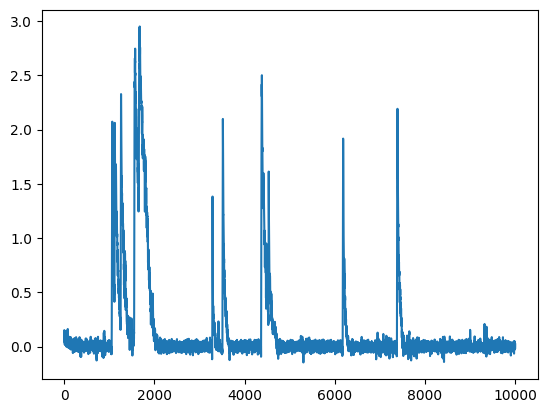

In [33]:
fig, ax = plt.subplots()
ax.plot(dff_trace[start_time:end_time, roi_num])

plt.show()

### Visualizing Fluorescence Over Time

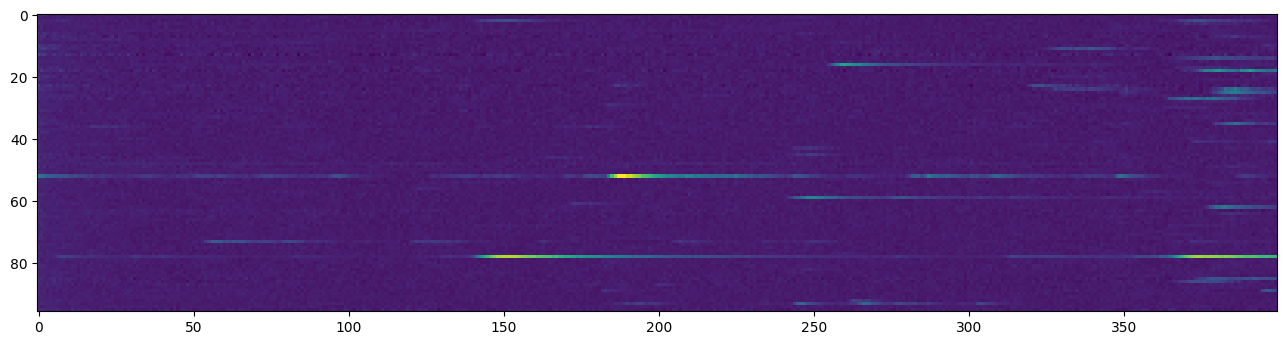

In [31]:
fig, ax = plt.subplots(figsize=(16,16))
img = ax.imshow(np.transpose(dff_trace[start_time:end_time]))
# cbar = plt.colorbar(img, shrink=0.5)
# cbar.set_label('# spikes')

# ax.yaxis.set_major_locator(plt.NullLocator())
# ax.set_ylabel("units", fontsize=16)

# xtick_step=20
# reltime = np.array(time_bin_edges)
# ax.set_xticks(np.arange(0, len(reltime), xtick_step))
# ax.set_xticklabels([f'{mp:1.3f}' for mp in reltime[::xtick_step]], rotation=45)

# ax.set_xlabel("time since stimulus event", fontsize=16)
# ax.set_title("unit spikes over time", fontsize=20)